In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional

In [2]:
tf.random.set_seed(1234)

In [3]:
df = pd.read_csv("data/EUR.csv", index_col = "Date")

In [4]:
df = df[['Close']]

In [5]:
train_size = int(len(df)*0.8)

train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

In [6]:
scaler = MinMaxScaler().fit(train_data)
train_scaled = scaler.transform(train_data)
test_scaled = scaler.transform(test_data)

In [7]:
# Create input dataset
def create_dataset (X, look_back = 1):
    Xs, ys = [], []
 
    for i in range(len(X)-look_back):
        v = X[i:i+look_back]
        Xs.append(v)
        ys.append(X[i+look_back])
 
    return np.array(Xs), np.array(ys)
LOOK_BACK = 100
X_train, y_train = create_dataset(train_scaled,LOOK_BACK)
X_test, y_test = create_dataset(test_scaled,LOOK_BACK)# Print data shape
print('X_train.shape:', X_train.shape)
print('y_train.shape:', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_test.shape)

X_train.shape: (3907, 100, 1)
y_train.shape: (3907, 1)
X_test.shape:  (902, 100, 1)
y_test.shape:  (902, 1)


In [8]:
def create_lstm(units):
    model = Sequential()
    # Input layer
    model.add(LSTM(units = units, return_sequences=True,input_shape=(X_train.shape[1], X_train.shape[2])))
    # Hidden layer
    model.add(LSTM(units = units))
    model.add(Dense(1))
    #Compile model
    model.compile(optimizer='adam',loss='mse')
    return model
model_lstm = create_lstm(64)
# Create BiLSTM model
def create_bilstm(units):
    model = Sequential()
    # Input layer
    model.add(Bidirectional(
              LSTM(units = units, return_sequences=True), 
              input_shape=(X_train.shape[1], X_train.shape[2])))
    # Hidden layer
    model.add(Bidirectional(LSTM(units = units)))
    model.add(Dense(1))
    #Compile model
    model.compile(optimizer='adam',loss='mse')
    return model
model_bilstm = create_bilstm(64)
# Create GRU model
# Create GRU model
def create_gru(units):
    model = Sequential()
    # Input layer
    model.add(GRU (units = units, return_sequences = True, 
    input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.2)) 
    # Hidden layer
    model.add(GRU(units = units)) 
    model.add(Dropout(0.2))
    model.add(Dense(units = 1)) 
    #Compile model
    model.compile(optimizer='adam',loss='mse')
    return model
model_gru = create_gru(64)

In [9]:
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 64)           16896     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________


In [10]:
model_gru.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 100, 64)           12864     
_________________________________________________________________
dropout (Dropout)            (None, 100, 64)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                24960     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 37,889
Trainable params: 37,889
Non-trainable params: 0
_________________________________________________________________


In [11]:
model_bilstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 100, 128)          33792     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 132,737
Trainable params: 132,737
Non-trainable params: 0
_________________________________________________________________


In [12]:
def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 30)
    history = model.fit(X_train, y_train, epochs = 100,  
                        validation_split = 0.2,
                        batch_size = 16, shuffle = False, 
                        callbacks = [early_stop],)
    return history
history_lstm = fit_model(model_lstm)
history_gru = fit_model(model_gru)
history_bilstm = fit_model(model_bilstm)

Epoch 1/100
196/196 [==============================] - 2s 12ms/step - loss: 0.0041 - val_loss: 0.0085
Epoch 2/100
196/196 [==============================] - 2s 9ms/step - loss: 0.0118 - val_loss: 0.0086
Epoch 3/100
196/196 [==============================] - 2s 9ms/step - loss: 0.0146 - val_loss: 0.0069
Epoch 4/100
196/196 [==============================] - 2s 9ms/step - loss: 0.0103 - val_loss: 0.0040
Epoch 5/100
196/196 [==============================] - 2s 9ms/step - loss: 0.0056 - val_loss: 5.1831e-04
Epoch 6/100
196/196 [==============================] - 2s 9ms/step - loss: 0.0029 - val_loss: 2.1803e-04
Epoch 7/100
196/196 [==============================] - 2s 9ms/step - loss: 0.0018 - val_loss: 2.3890e-04
Epoch 8/100
196/196 [==============================] - 2s 9ms/step - loss: 0.0014 - val_loss: 1.8162e-04
Epoch 9/100
196/196 [==============================] - 2s 9ms/step - loss: 0.0013 - val_loss: 1.5653e-04
Epoch 10/100
196/196 [==============================] - 2s 8ms/step - 

In [13]:
y_test = scaler.inverse_transform(y_test)
y_train = scaler.inverse_transform(y_train)

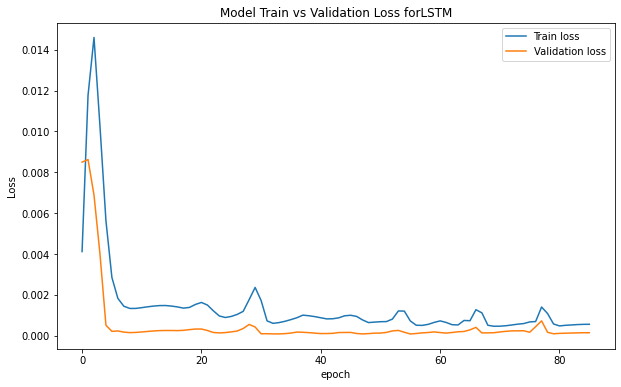

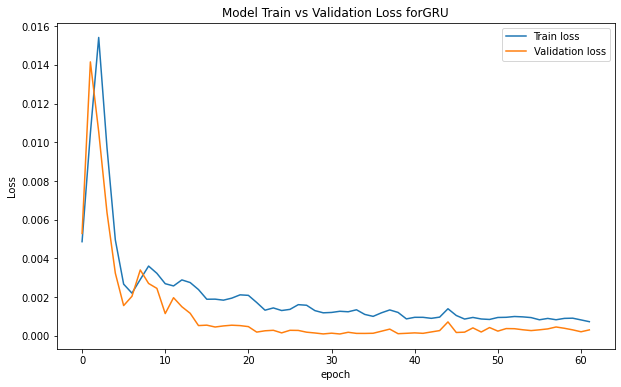

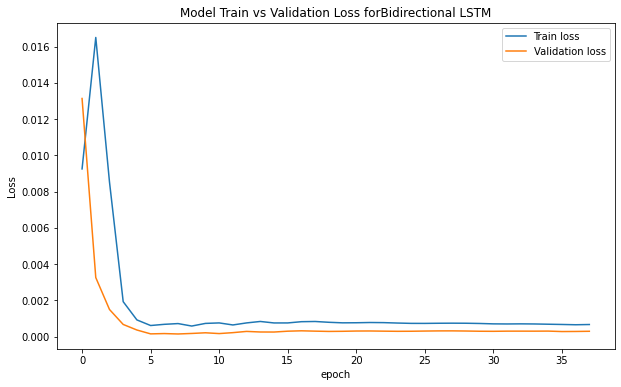

In [14]:
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')

plot_loss (history_lstm, 'LSTM')
plot_loss (history_gru, 'GRU')
plot_loss (history_bilstm, 'Bidirectional LSTM')

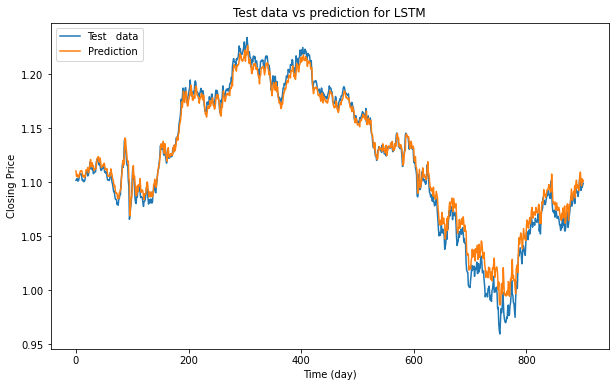

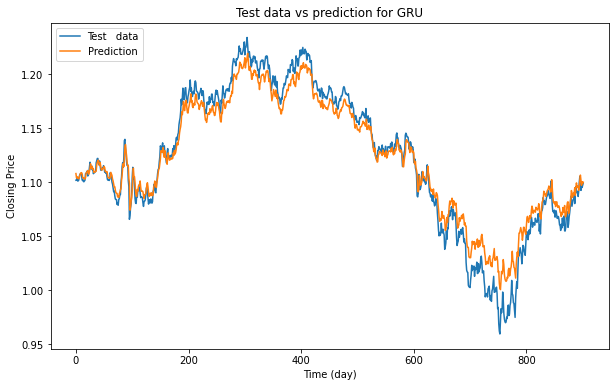

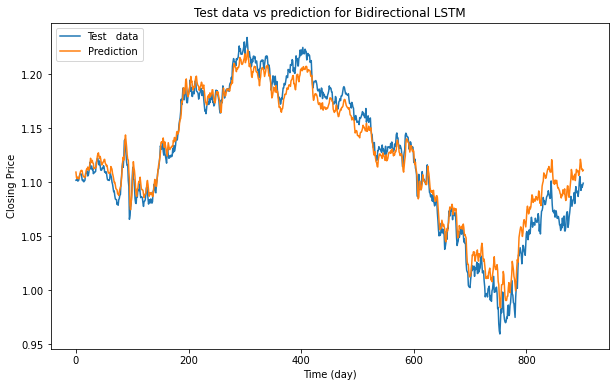

In [22]:
# Make prediction
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler.inverse_transform(prediction)
    return prediction
prediction_lstm = prediction(model_lstm)
prediction_gru = prediction(model_gru)
prediction_bilstm = prediction(model_bilstm)
# Plot test data vs prediction
def plot_future(prediction, model_name, y_test):
    plt.figure(figsize=(10, 6))
    range_future = len(prediction)
    plt.plot(np.arange(range_future), np.array(y_test), 
             label='Test   data')
    plt.plot(np.arange(range_future), 
             np.array(prediction),label='Prediction')
    plt.title('Test data vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Time (day)')
    plt.ylabel('Closing Price')

plot_future(prediction_lstm, 'LSTM', y_test)
plot_future(prediction_gru, 'GRU', y_test)
plot_future(prediction_bilstm, 'Bidirectional LSTM', y_test)

In [23]:
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('')
evaluate_prediction(prediction_lstm, y_test, 'lstm')
evaluate_prediction(prediction_gru, y_test, 'GRU')
evaluate_prediction(prediction_bilstm, y_test, 'Bidirectiona LSTM')

lstm:
Mean Absolute Error: 0.0071
Root Mean Square Error: 0.0094

GRU:
Mean Absolute Error: 0.0108
Root Mean Square Error: 0.0138

Bidirectiona LSTM:
Mean Absolute Error: 0.0106
Root Mean Square Error: 0.0132



In [27]:
model_lstm.save('EUR_CLOSE_LSTM.h5')
model_bilstm.save('EUR_CLOSE_BiLSTM.h5')
model_gru.save('EUR_CLOSE_GRU.h5')

In [ ]:
# import IPython
# app = IPython.Application.instance()
# app.kernel.do_shutdown(True)

In [ ]:
X_100=df.tail(200)
# Make prediction for new data
def prediction(model):
    prediction = model.predict(X_100)
    prediction = scaler.inverse_transform(prediction)
    return prediction
prediction_lstm = prediction(model_lstm)
prediction_gru = prediction(model_gru)
prediction_bilstm = prediction(model_bilstm)
# Plot history and future
def plot_multi_step(history, prediction1, prediction2, prediction3):
    
    plt.figure(figsize=(15, 6))
    
    range_history = len(history)
    range_future = list(range(range_history, range_history +
                        len(prediction1)))
    plt.plot(np.arange(range_history), np.array(history), 
             label='History')
    plt.plot(range_future, np.array(prediction1),
             label='Forecasted for LSTM')
    plt.plot(range_future, np.array(prediction2),
             label='Forecasted for GRU')
    plt.plot(range_future, np.array(prediction3),
             label='Forecasted for BiLSTM')
      
    plt.legend(loc='upper right')
    plt.xlabel('Time step (day)')
    plt.ylabel('Closing Price')
        
plot_multi_step(X_100,prediction_lstm, prediction_gru, prediction_bilstm)